This notebook template is designed for testing the performance of Rotatron environments and different solving agents of different scales.

In [3]:
# =============================================================================
# Work on local biobuild in GIT repo
# =============================================================================
import os, sys, importlib

# for inside python scripts
# base = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(__file__))))
base = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, base)

def reload_optimizers():
    importlib.reload(bam.optimizers.environments)
    importlib.reload(bam.optimizers.agents)
# =============================================================================
import files
import auxiliary
import buildamol as bam
import buildamol.optimizers.environments as envs
import buildamol.optimizers.agents as agents
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
from collections import defaultdict

import time
import numpy as np
import pandas as pd

Here we can select which tests to run and on what testing structures:

In [4]:
# which structures to run on
structures_to_run_on = [
    # files.GLUCOSE2,
    # files.PEPTIDE,
    files.X_WING,
    # files.X_WING2,
    # files.SCAFFOLD1,
    # files.SCAFFOLD3,
]

# how many times to independently run on each structure
re_runs = 1

# visualize evaluation history
visualize_eval_history = True

# visualize time history
visualize_time_history = True

# visualise clashes in final structure
visualize_clashes = True

# clash threshold
clash_cutoff = 0.8

# visualize the final structure
visualize_final_structure = False

# visualization parameters
# for draw_edges()
visualization_params = dict(color="magenta", opacity=0.3)

# export visualization to html
export_visualization = False

# export solutions as PDB
export_pdb = True

# export history to csv
export_history = True

# export name prefix
export_name_prefix = None

# graph building function
# provide a custom callable that generates a tuple of (graph, rotatable_edges)
def make_graph(structure:bam.Molecule):
    graph = structure.get_atom_graph()
    # graph = structure.make_residue_graph()
    # graph.make_detailed(n_samples=0.5)
    edges = graph.find_rotatable_edges(min_descendants=20, min_ancestors=20)
    edges = graph.direct_edges(root_node=structure.get_atom("Cl1"), edges=edges, adopt=True)
    return graph, edges

graph_factory = make_graph

# graph building parameters
graph_params = {}

# provide a custom callable to set a custom building function for the environment
rotatron_factory = None

# the rotatron class to use
rotatron_class = envs.DistanceRotatron

# rotatron parameters
rotatron_params = {"pushback": 4, "radius": -1}

# the agent function to use
# agent = agents.nelder_mead_optimize
# agent_params = {}
agent = agents.swarm_optimize
agent_params = {"max_steps":10, "n_particles":10, "variation" : 0.2}#{"bounds":(-np.pi/2, np.pi/2)}

# agent = agents.newton_like_optimize

# # agent parameters
# agent_params = {"max_steps" : 300}   


Perform some environment setup

In [5]:
if agent is None:
    raise ValueError("No agent provided")
if rotatron_class is None:
    raise ValueError("No rotatron class provided")
    
if graph_factory is None:
    graph_factory = auxiliary.graph_factory
if rotatron_factory is None:
    rotatron_factory = auxiliary.rotatron_factory

available_structures = {}

eval_history = defaultdict(list)
time_history = defaultdict(list)
clash_history = defaultdict(list)
final_visuals = {}
initial_evals = {}
initial_clashes = {}
v = None

if not export_name_prefix:
    export_name_prefix = rotatron_class.__name__ + "." + agent.__name__

def make_environment(structure):
    """
    An environment generator
    """
    graph, rotatable_edges = graph_factory(structure, **graph_params)
    return rotatron_factory(rotatron_class, graph, rotatable_edges, **rotatron_params)


Now start the main testing code

In [6]:
structure = bam.molecule(structures_to_run_on[0])

In [7]:
# structure.rotate_descendants(10, 24, 50)
structure.show()

In [8]:
edges = [(structure.get_atom(68), structure.get_atom(65)), (structure.get_atom(151), structure.get_atom(148))]
graph = structure.get_atom_graph()

env = envs.DistanceRotatron(graph, edges)


env._best_eval, env._best_clashes, edges

(490.8546916933573,
 6,
 [(Atom(C4, 68), Atom(C3, 65)), (Atom(C4, 151), Atom(C3, 148))])

Text(0.5, 1.0, 'Evaluation function')

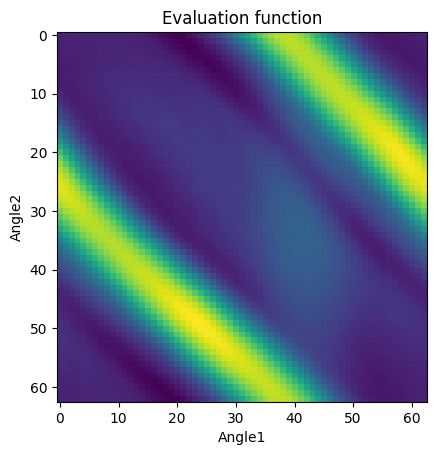

In [13]:

angles = np.arange(0, np.pi*2, 0.1)

env = envs.DistanceRotatron(graph, edges, radius=15, mask_rotation_units=True)

evals = np.zeros((len(angles), len(angles)))

idx = 0
for angle1 in angles:
    jdx = 0
    for angle2 in angles:
        state, eval, *_ = env.step([angle1, angle2])
        evals[idx, jdx] = eval
        jdx += 1
        env.reset()
    idx += 1

evals /= evals.max()
fig, ax = plt.subplots()
ax.imshow(evals)
ax.set(xlabel="Angle1", ylabel="Angle2")
ax.set_title("Evaluation function")


In [19]:
angle1, angle2 = np.where(evals == evals.min())

(array([1]), array([21]))

In [21]:
# env = envs.DistanceRotatron(graph, edges)

animation_frames = []
# evals = np.zeros_like(angles)

# idx = 0
# for angle in angles:
#     state, eval, *_ = env.step([angle])
#     evals[idx] = eval
#     env.reset()
#     idx += 1

# _e = -evals + evals.max()
# _e = _e / _e.max()
# for i, angle in enumerate(angles):
#     v = env.graph.draw()
#     s = structure.copy()
#     s.rotate_descendants(68, 65, angle, angle_is_degrees=False)
#     v.draw_edges(*s.bonds, color="blue", opacity = _e[i] ) 
#     animation_frames.append(go.Frame(data=v.figure.data))

angle1, angle2 = np.where(evals == evals.min())
angle1 = angles[angle1[0]]
angle2 = angles[angle2[0]]

s = structure.copy()
v = s.draw()
animation_frames.append(go.Frame(data=v.figure.data))

s.rotate_descendants(68, 65, angle1, angle_is_degrees=False)
v.draw_edges(*s.bonds, color="red", opacity = 1)
animation_frames.append(go.Frame(data=v.figure.data))
s.rotate_descendants(151, 148, angle2, angle_is_degrees=False)
v.draw_edges(*s.bonds, color="green", opacity = 1)
animation_frames.append(go.Frame(data=v.figure.data))

anim = go.Figure(
    data=v.figure.data,
    layout=v.figure.layout,
    frames=animation_frames,
)
anim.write_html("animation-2edge.html")

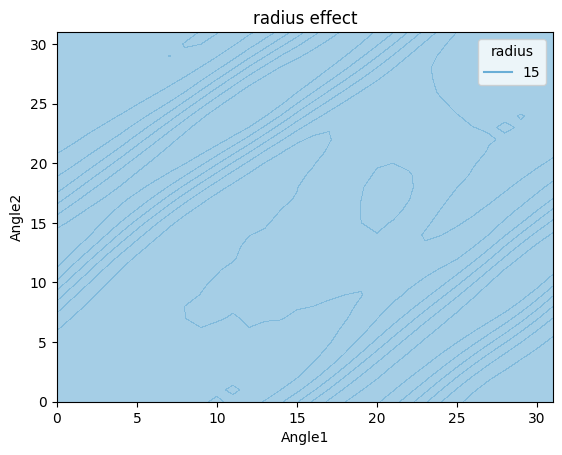

In [46]:

angles = np.arange(0, np.pi*2, 0.2)

fig, ax = plt.subplots()

radii = [15]
cmap = sns.color_palette("Blues", len(radii))
rdx = 0
for radius in radii:
    env = envs.DistanceRotatron(graph, edges, radius=radius)
    
    evals = np.zeros((len(angles), len(angles)))

    idx = 0
    for angle1 in angles:
        jdx = 0
        for angle2 in angles:
            state, eval, *_ = env.step([angle1, angle2])
            evals[idx, jdx] = eval
            jdx += 1
            env.reset()
        idx += 1
    
    evals /= evals.max()
    ax.contourf(evals, colors=[cmap[rdx]], alpha=0.6)
    rdx += 1
    
ax.set(xlabel="Angle1", ylabel="Angle2")
ax.set_title("Evaluation function")
ax.set_title("radius effect")
ax.legend(handles=[
    plt.Line2D([0], [0], color=cmap[i], label=f"{r}") for i, r in enumerate(radii)
], labels=[f"{r}" for r in radii], title="radius")

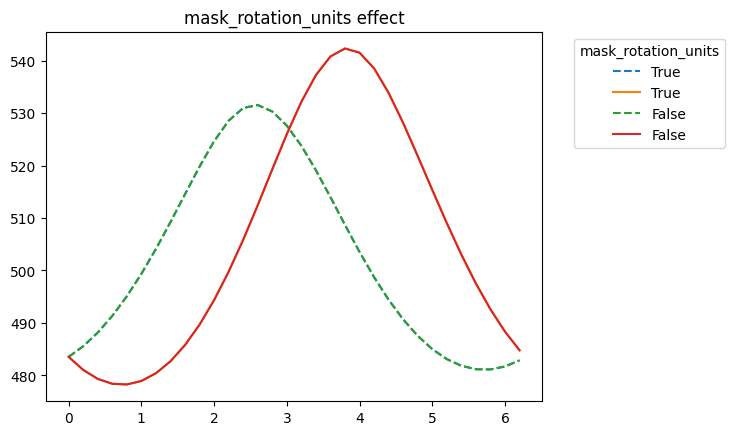

In [54]:
for i in (True, False):
    env = envs.DistanceRotatron(graph, edges, mask_rotation_units=i, radius=-1)

    evals1 = np.zeros_like(angles)
    evals2 = np.zeros_like(angles)

    idx = 0
    for angle1 in angles:
        state, eval, *_ = env.step([angle1, 0])
        evals1[idx] = eval
        env.reset()
        state, eval, *_ = env.step([0, angle1])
        evals2[idx] = eval
        env.reset()
        idx += 1

    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals1, label=i, ls="--")
    sns.lineplot(x=angles, y=evals2, label=i, ax=ax)
    ax.legend(bbox_to_anchor=(1.05, 1)).set_title("mask_rotation_units")
    ax.set_title("mask_rotation_units effect")

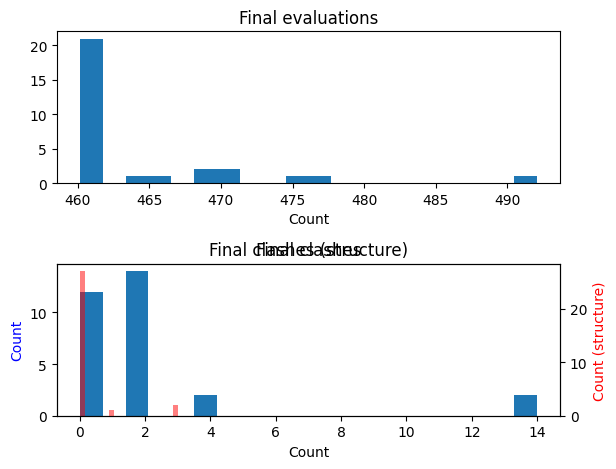

In [64]:
edges.append(
    (structure.get_atom(79), structure.get_atom(68))
)
edges.append(
    (structure.get_atom(79), structure.get_atom(151))
)
env = envs.DistanceRotatron(graph, edges, radius=-1)

re_runs = 30
final_evals = np.zeros(re_runs)
final_clashes = np.zeros(re_runs)
final_s_clashes = np.zeros(re_runs)
for i in range(re_runs):
        
    sol, eval = agents.scipy_optimize(env, steps=100000)

    final = auxiliary.apply_solution(sol, env, structure.copy())
    final_evals[i] = eval
    final_s_clashes[i] = len(final.find_clashes())
    final_clashes[i] = env.count_clashes()
    
fig, ax = plt.subplots(2)
ax[0].hist(final_evals, bins=20)
ax[0].set_title("Final evaluations")
ax[1].hist(final_clashes, bins=20)
ax[1].set_title("Final clashes")
ax1 = ax[1].twinx()
ax1.hist(final_s_clashes, bins=20, color="red", alpha=0.5)
ax1.set_title("Final clashes (structure)")
ax1.set_ylabel("Count (structure)", color="red")
ax[1].set_ylabel("Count", color="blue")
ax[1].set_xlabel("Count")
ax[0].set_xlabel("Count")

plt.tight_layout()